In [103]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [104]:
orders_raw = pd.read_csv('Data/orders.csv')

In [105]:
orders_raw.columns= orders_raw.columns.str.lower()
orders_raw['created_at'] = pd.to_datetime(orders_raw['created_at']).dt.date


In [106]:
orders_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22050 entries, 0 to 22049
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   id                               22050 non-null  int64 
 1   user_id                          22050 non-null  int64 
 2   created_at                       22050 non-null  object
 3   product_id                       22050 non-null  int64 
 4   total_cost_pennies               22050 non-null  int64 
 5   total_cost_pre_discount_pennies  22050 non-null  int64 
 6   source                           22050 non-null  object
dtypes: int64(5), object(2)
memory usage: 1.2+ MB


In [107]:
orders_raw.head(5)

,id,user_id,created_at,product_id,total_cost_pennies,total_cost_pre_discount_pennies,source
0,110786050,440133,2017-03-23,193,1800,2000,web
1,114247432,386193,2019-10-09,1782,1870,2200,web
2,114242128,1747736,2019-10-08,2148,3200,4200,web
3,114259699,860466,2019-10-11,1773,2520,2800,web
4,115048004,974101,2020-01-30,2364,3390,3900,web


In [108]:
orders_days  = pd.DataFrame(orders_raw.groupby('created_at').id.count().rename('volume')).reset_index()

revenue_days = orders_raw.groupby('created_at').total_cost_pennies.sum().rename('revenue')

full_revenue_days = orders_raw.groupby('created_at').total_cost_pre_discount_pennies.sum().rename('full_revenue')

orders_days = (orders_days.merge(revenue_days, on = 'created_at', how = 'left')
                        .merge(full_revenue_days, on = 'created_at', how = 'left'))


In [109]:
orders_days.sort_values('created_at')

,created_at,volume,revenue,full_revenue
0,2013-08-28,1,1695,1695
1,2013-12-15,1,3163,4001
2,2013-12-23,2,8000,8000
3,2014-02-07,1,4000,4000
4,2014-03-05,1,2795,2795
...,...,...,...,...
1883,2020-09-11,27,84095,91200
1884,2020-09-12,17,44905,51100
1885,2020-09-13,20,57465,64000
1886,2020-09-14,62,173740,204300


In [111]:
# discounts bins [[0], [1:20], [21:40], [50:99], [100]]

orders_raw['discount'] = (((orders_raw.total_cost_pre_discount_pennies - orders_raw.total_cost_pennies)
                            / orders_raw.total_cost_pre_discount_pennies)*100).round(1)
orders_raw['discount_type'] = np.where(orders_raw.discount == 0, 1 , 0)
orders_raw['discount_type'] = np.where(((orders_raw.discount > 0) &(orders_raw.discount <= 20)), 
                                       2 , orders_raw.discount_type)
orders_raw['discount_type'] = np.where(((orders_raw.discount > 20) &(orders_raw.discount <= 50)), 
                                       3 , orders_raw.discount_type)
orders_raw['discount_type'] = np.where(((orders_raw.discount > 50) &(orders_raw.discount < 100)), 
                                       4 , orders_raw.discount_type)
orders_raw['discount_type'] = np.where(orders_raw.discount ==100, 5 , orders_raw.discount_type)


In [112]:
for i in range(1,6):
    orders_days = orders_days.merge(orders_raw[orders_raw.discount_type == i]
    .groupby('created_at').id.count().fillna(0).rename('disc'+ str(i)), on = 'created_at', how = 'left')


In [113]:
orders_days.sort_values('created_at')

,created_at,volume,revenue,full_revenue,disc1,disc2,disc3,disc4,disc5
0,2013-08-28,1,1695,1695,1.0,NaN,NaN,NaN,NaN
1,2013-12-15,1,3163,4001,NaN,NaN,1.0,NaN,NaN
2,2013-12-23,2,8000,8000,2.0,NaN,NaN,NaN,NaN
3,2014-02-07,1,4000,4000,1.0,NaN,NaN,NaN,NaN
4,2014-03-05,1,2795,2795,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1883,2020-09-11,27,84095,91200,13.0,12.0,2.0,NaN,NaN
1884,2020-09-12,17,44905,51100,6.0,10.0,1.0,NaN,NaN
1885,2020-09-13,20,57465,64000,5.0,14.0,1.0,NaN,NaN
1886,2020-09-14,62,173740,204300,11.0,45.0,5.0,1.0,NaN


In [115]:
orders_days.to_csv('Data/volume_of_disc.csv')

In [77]:
orders_raw = (orders_raw.merge(orders_raw.groupby('user_id').created_at.min()
                              .rename('first_order_date'), on = 'user_id'))
orders_raw['first_order'] = orders_raw.created_at == orders_raw.first_order_date

In [79]:
products = orders_raw.groupby('created_at').product_id.nunique().rename('products')
users = orders_raw.groupby('created_at').user_id.nunique().rename('users')
first_orders = orders_raw[orders_raw.first_order].groupby('created_at').user_id.nunique().rename('new_users')

In [80]:
orders_days.sort_values('created_at')

,created_at,volume,revenue,full_revenue,disc1,disc2,disc3,disc4,disc5
0,2013-08-28,1,1695,1695,1.0,NaN,NaN,NaN,NaN
1,2013-12-15,1,3163,4001,NaN,NaN,1.0,NaN,NaN
2,2013-12-23,2,8000,8000,2.0,NaN,NaN,NaN,NaN
3,2014-02-07,1,4000,4000,1.0,NaN,NaN,NaN,NaN
4,2014-03-05,1,2795,2795,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1883,2020-09-11,27,84095,91200,13.0,12.0,2.0,NaN,NaN
1884,2020-09-12,17,44905,51100,6.0,10.0,1.0,NaN,NaN
1885,2020-09-13,20,57465,64000,5.0,14.0,1.0,NaN,NaN
1886,2020-09-14,62,173740,204300,11.0,45.0,5.0,1.0,NaN


In [81]:
orders_raw.source.unique()

array(['web', 'iOS', 'Android', 'Magento', 'Website', 'import'],
      dtype=object)

In [82]:
orders_raw.source = np.where(orders_raw.source == 'web', 'Website', orders_raw.source)
orders_raw.source = np.where(((orders_raw.source == 'Android') | (orders_raw.source == 'iOS')), 
                             'Mobile', orders_raw.source)

sources = pd.DataFrame(orders_raw.groupby(['created_at', 'source']).id.count().rename('val')).reset_index()

orders_days  = (orders_days.merge(sources.pivot(index = 'created_at', 
                columns = 'source', values = 'val').fillna(0).reset_index(), on = 'created_at', how = 'left')
                .merge(products, on = 'created_at', how = 'left')
                .merge(users, on = 'created_at', how = 'left')
                .merge(first_orders, on = 'created_at', how = 'left'))

In [83]:
orders_days.sort_values('created_at')

,created_at,volume,revenue,full_revenue,disc1,disc2,disc3,disc4,disc5,Magento,Mobile,Website,import,products,users,new_users
0,2013-08-28,1,1695,1695,1.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,1,1,1.0
1,2013-12-15,1,3163,4001,NaN,NaN,1.0,NaN,NaN,1.0,0.0,0.0,0.0,1,1,1.0
2,2013-12-23,2,8000,8000,2.0,NaN,NaN,NaN,NaN,2.0,0.0,0.0,0.0,1,1,1.0
3,2014-02-07,1,4000,4000,1.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,1,1,1.0
4,2014-03-05,1,2795,2795,1.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,1,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1883,2020-09-11,27,84095,91200,13.0,12.0,2.0,NaN,NaN,0.0,13.0,14.0,0.0,15,24,1.0
1884,2020-09-12,17,44905,51100,6.0,10.0,1.0,NaN,NaN,0.0,7.0,10.0,0.0,9,15,1.0
1885,2020-09-13,20,57465,64000,5.0,14.0,1.0,NaN,NaN,0.0,7.0,13.0,0.0,13,17,1.0
1886,2020-09-14,62,173740,204300,11.0,45.0,5.0,1.0,NaN,0.0,24.0,38.0,0.0,28,55,NaN


In [84]:
orders_days = orders_days.fillna(0)

In [85]:
def crosscorr(datax, datay, lag=0):
    return datax.corr(datay.shift(lag))

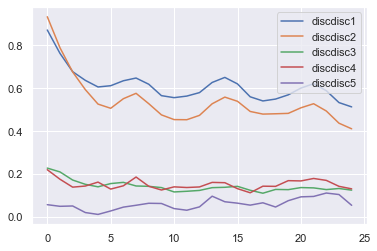

In [97]:
disc = ['disc1', 'disc2', 'disc3', 'disc4', 'disc5']

for i in disc:
    xcov_daily = [crosscorr(orders_days.users, orders_days[i], lag=k) for k in range(25)]
    plt.plot(xcov_daily, label= 'disc' + str(i))
    plt.legend()

disc1 = 1-3, 6, 14
disc2 = 1-4, 7, 14
disc3 = 1
disc4 = 2, 12
disc5 = 1, 13

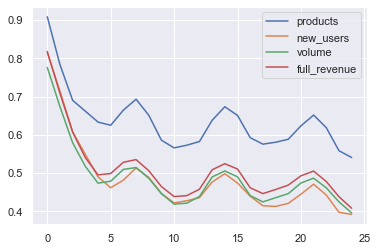

In [100]:
other_features = ['products', 'new_users', 'volume', 'full_revenue']

for i in other_features:
    xcov_daily = [crosscorr(orders_days.users, orders_days[i], lag=k) for k in range(25)]
    plt.plot(xcov_daily, label= str(i))
    plt.legend()

In [ ]:
1-3, 7,14

In [54]:
users = orders_raw.groupby('created_at').user_id.nunique().rename('user_bought')

In [55]:
orders_days['created_at'] = pd.to_datetime(orders_raw['created_at'])

time-trends

In [56]:
usual_day = orders_days[orders_days['volume'] <100]

In [57]:
last_years = usual_day[usual_day['created_at'] > '2018-06-23']

<AxesSubplot:xlabel='created_at', ylabel='volume'>

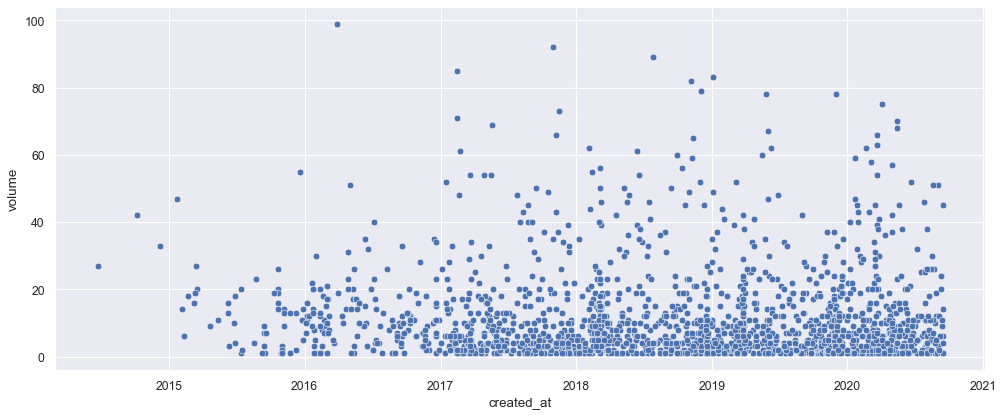

In [58]:
plt.figure(figsize=(15, 6), dpi=80)
sns.set_theme(style="darkgrid")
sns.scatterplot(x="created_at", y="volume",
             data=usual_day )


In [96]:
orders_days.to_csv('Data/orders_days.csv')

In [60]:
orders_days.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1888 entries, 0 to 1887
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   created_at    1888 non-null   datetime64[ns]
 1   volume        1888 non-null   int64         
 2   revenue       1888 non-null   int64         
 3   full_revenue  1888 non-null   int64         
 4   disc1         1888 non-null   float64       
 5   disc2         1888 non-null   float64       
 6   disc3         1888 non-null   float64       
 7   disc4         1888 non-null   float64       
 8   disc5         1888 non-null   float64       
 9   Magento       1888 non-null   float64       
 10  Mobile        1888 non-null   float64       
 11  Website       1888 non-null   float64       
 12  import        1888 non-null   float64       
 13  products      1888 non-null   int64         
 14  users         1888 non-null   int64         
 15  new_users     1888 non-null   float64 

In [61]:
orders_days.sort_values('created_at')

,created_at,volume,revenue,full_revenue,disc1,disc2,disc3,disc4,disc5,Magento,Mobile,Website,import,products,users,new_users
1794,2014-06-23,27,77320,85300,14.0,9.0,4.0,0.0,0.0,0.0,10.0,17.0,0.0,13,26,1.0
1788,2014-10-07,42,130745,150500,16.0,17.0,9.0,0.0,0.0,0.0,17.0,25.0,0.0,17,40,6.0
1795,2014-12-08,33,100530,114900,15.0,12.0,5.0,0.0,1.0,0.0,8.0,25.0,0.0,18,30,7.0
1798,2015-01-24,47,142730,157100,23.0,18.0,6.0,0.0,0.0,0.0,12.0,35.0,0.0,19,39,4.0
1678,2015-02-05,14,40820,44200,6.0,8.0,0.0,0.0,0.0,0.0,6.0,8.0,0.0,10,14,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,2020-09-14,1,2000,2000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,0.0
354,2020-09-14,6,13055,15400,3.0,1.0,2.0,0.0,0.0,0.0,1.0,5.0,0.0,5,6,3.0
587,2020-09-14,14,48180,56800,4.0,4.0,6.0,0.0,0.0,0.0,2.0,12.0,0.0,9,12,10.0
1600,2020-09-14,45,129537,163300,2.0,26.0,17.0,0.0,0.0,0.0,5.0,40.0,0.0,28,42,10.0


In [62]:
grid_search = orders_days[['volume','disc1', 'disc2', 'disc3','disc4','disc5', 'users']]

In [63]:
grid_search 

,volume,disc1,disc2,disc3,disc4,disc5,users
0,1,1.0,0.0,0.0,0.0,0.0,1
1,1,0.0,0.0,1.0,0.0,0.0,1
2,2,2.0,0.0,0.0,0.0,0.0,1
3,1,1.0,0.0,0.0,0.0,0.0,1
4,1,1.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...
1883,27,13.0,12.0,2.0,0.0,0.0,24
1884,17,6.0,10.0,1.0,0.0,0.0,15
1885,20,5.0,14.0,1.0,0.0,0.0,17
1886,62,11.0,45.0,5.0,1.0,0.0,55


In [64]:
grid_search.to_csv('grid_search.csv')